In [1]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import jdatetime
from datetime import datetime
pd.set_option('display.encoding', 'utf-8')
plt.style.use('seaborn-notebook')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20392\349334122.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


In [2]:
df = pd.read_csv(
    'houseData.csv',
    index_col=[0]
)

print(df.info())
print('-' * 30)
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 0 to 835
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Area       836 non-null    object
 1   YearBuilt  836 non-null    object
 2   Rooms      836 non-null    object
 3   Location   836 non-null    object
 4   Price      836 non-null    object
 5   Floor      836 non-null    object
dtypes: object(6)
memory usage: 45.7+ KB
None
------------------------------
       Area YearBuilt Rooms     Location        Price Floor
count   836       836   836          836          836   836
unique  188        32     6          172          458    46
top     ۱۱۰      ۱۴۰۲     ۲   سعادت‌آباد  ۱۴۵۰۰۰۰۰۰۰۰     0
freq     28       141   426           47           12   109


In [3]:
def persianDigitToEnglish(value):
    return unidecode(value)

numeric_columns = ['Area', 'YearBuilt', 'Rooms', 'Price', 'Floor']
text_column = 'Location'    

df[numeric_columns] = df[numeric_columns].applymap(persianDigitToEnglish)

In [4]:
df['Area'] = df['Area'].astype(np.uint16)
df['YearBuilt'] = df['YearBuilt'].astype(np.uint16)
df['Rooms'] = df['Rooms'].astype(np.uint8)
df['Price'] = df['Price'].astype(np.uint64)
df['Floor'] = df['Floor'].astype(np.uint8)
df['PricePerM2'] = (df['Price'] / df['Area']).round()
df['Location'] = df['Location'].str.strip()

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 0 to 835
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        836 non-null    uint16 
 1   YearBuilt   836 non-null    uint16 
 2   Rooms       836 non-null    uint8  
 3   Location    836 non-null    object 
 4   Price       836 non-null    uint64 
 5   Floor       836 non-null    uint8  
 6   PricePerM2  836 non-null    float64
dtypes: float64(1), object(1), uint16(2), uint64(1), uint8(2)
memory usage: 31.0+ KB
None


,Area,YearBuilt,Rooms,Location,Price,Floor,PricePerM2
0,87,1400,2,مرزداران,13920000000,7,160000000.0
1,98,1397,2,کوی فردوس,10600000000,5,108163265.0
2,60,1396,1,ابراهیم‌آباد,1560000000,1,26000000.0
3,87,1394,2,سازمان برنامه,9500000000,3,109195402.0
4,170,1375,3,فرمانیه,34000000000,2,200000000.0


In [5]:
def calculate_age(year):
    today_date = datetime.now()
    persian_date = jdatetime.GregorianToJalali(gyear=today_date.year, gmonth=today_date.month, gday=today_date.day)
    return persian_date.jyear - year

df['BuildingAge'] = df['YearBuilt'].map(calculate_age)

In [6]:
df = df.drop(['YearBuilt', 'Price'], axis=1)
df.head()

,Area,Rooms,Location,Floor,PricePerM2,BuildingAge
0,87,2,مرزداران,7,160000000.0,2
1,98,2,کوی فردوس,5,108163265.0,5
2,60,1,ابراهیم‌آباد,1,26000000.0,6
3,87,2,سازمان برنامه,3,109195402.0,8
4,170,3,فرمانیه,2,200000000.0,27


In [7]:
test = df.groupby(['Location', 'Rooms']).mean()
test.index[0][0]
test.loc['فرمانیه', 2]

Area                  97.5
Floor                  2.0
PricePerM2     143767123.5
BuildingAge            1.5
Name: (فرمانیه, 2), dtype: float64

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20392\3931735684.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


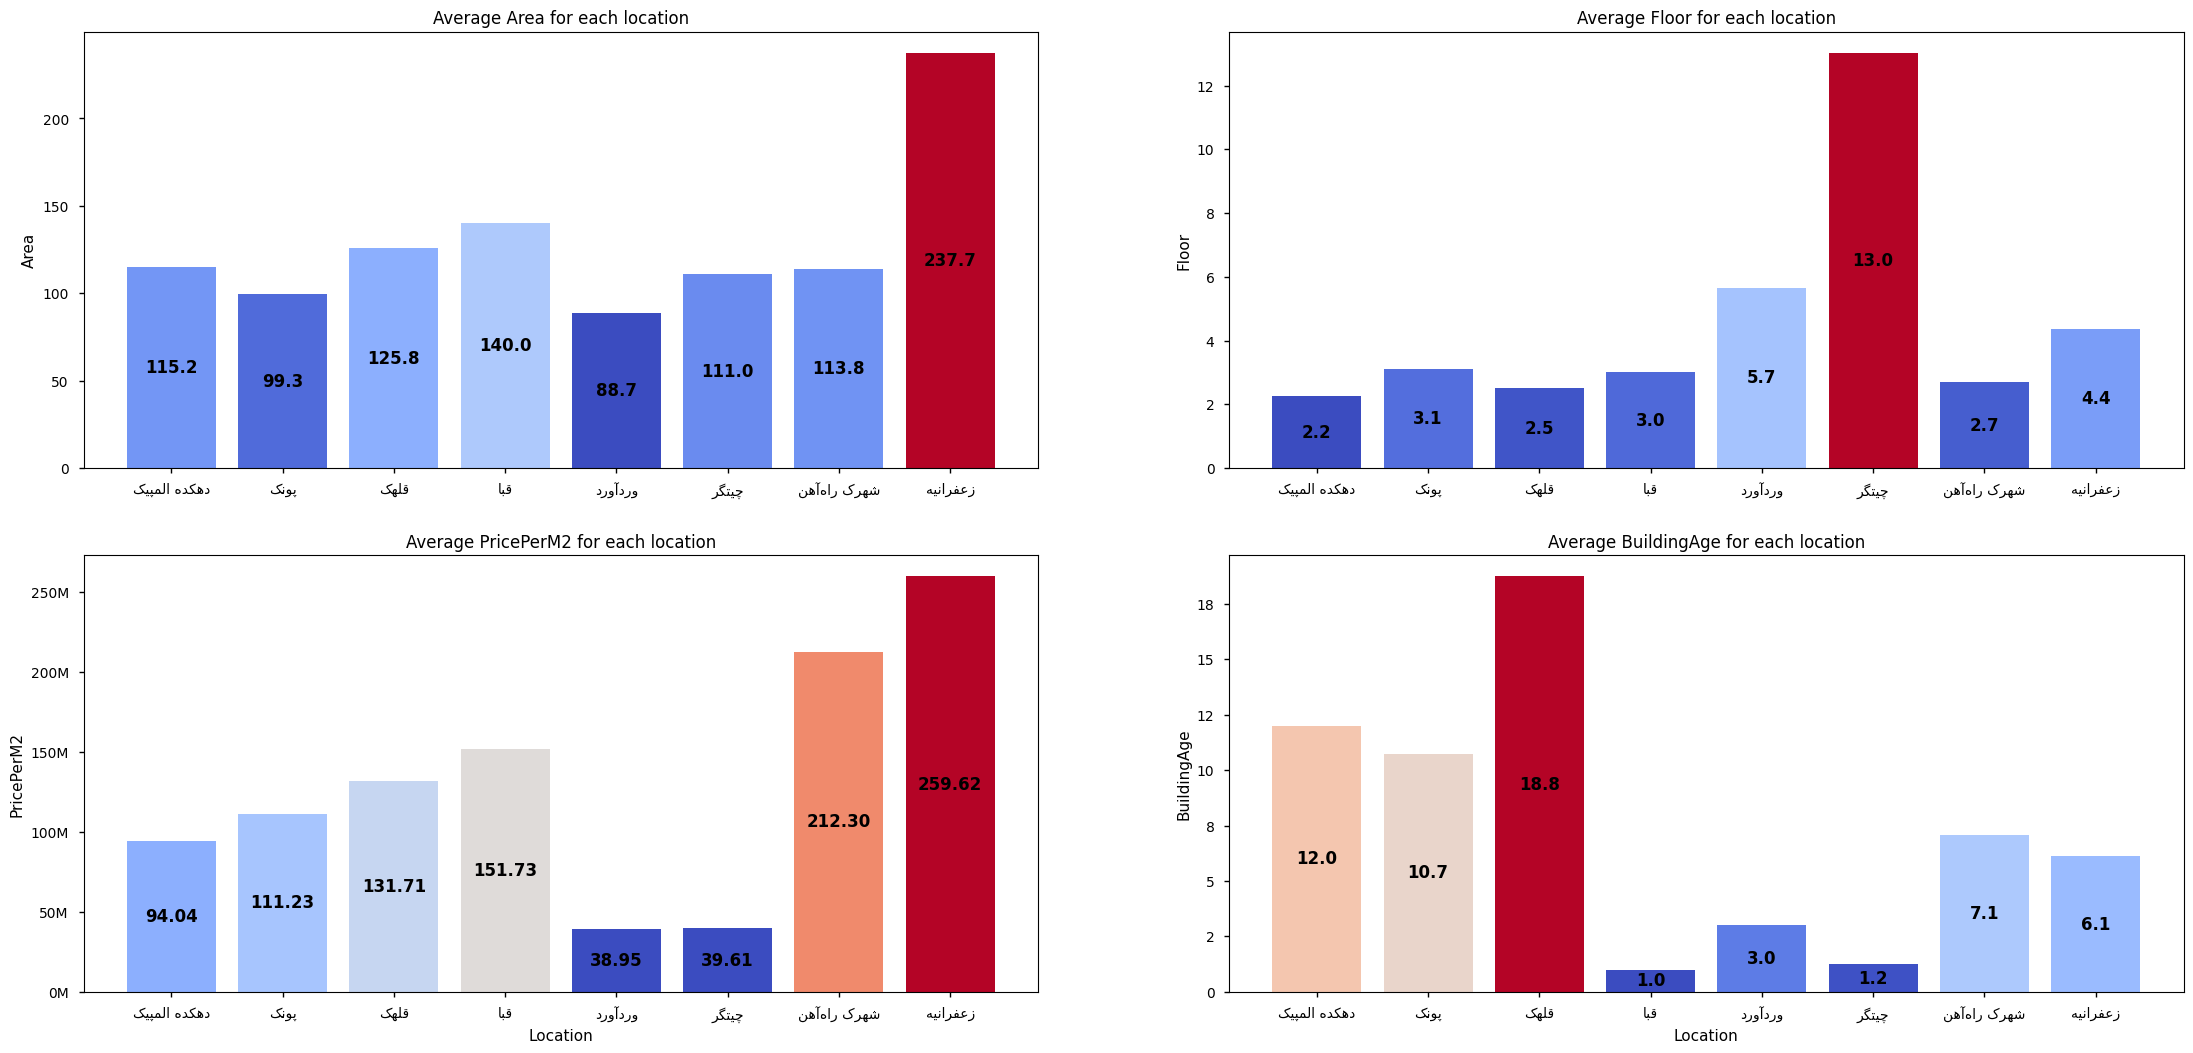

In [8]:
from bidi import algorithm as bidi_algorithm
import arabic_reshaper
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib import cm

def add_value_label(bars: plt, ax):
    for bar in bars:
        value = bar


top_10_locations_idx = df['Location'].value_counts(ascending=False)[:10]
top_10_locations = df.loc[top_10_locations_idx, 'Location']

df_top_10_location = df[df['Location'].isin(top_10_locations)]
df_top_10_location.loc[:, "Location"] = df_top_10_location.loc[:, 'Location'].map(
                                        lambda x: (bidi_algorithm.get_display(arabic_reshaper.reshape(x))))

mean_values_location = df_top_10_location.groupby('Location').mean()
mean_values_location.drop('Rooms', axis=1, inplace=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 12))
axes = axes.flatten()
cmap = cm.get_cmap('coolwarm')
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

for i, ax in enumerate(axes):
    col = mean_values_location.columns[i]
    bars = ax.bar(mean_values_location.index, mean_values_location.loc[:, col].values, align='center', color=cmap(rescale(mean_values_location.loc[:, col].values)))
    if col == 'PricePerM2':
        ax.bar_label(bars, fmt=lambda x: '{:.2f}'.format(x/1e+6) , label_type='center', fontsize=12, color='black', weight='bold')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}M'.format(x / 1e6)))
    else:
        ax.bar_label(bars, fmt=lambda x: '{:.1f}'.format(x) , label_type='center', fontsize=12, color='black', weight='bold')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x/1)))
    ax.set_ylabel(col)
    if i >= 2:
        ax.set_xlabel('Location')
    ax.set_title(f"Average {col} for each location")


# plt.tight_layout()
plt.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

plt.show()

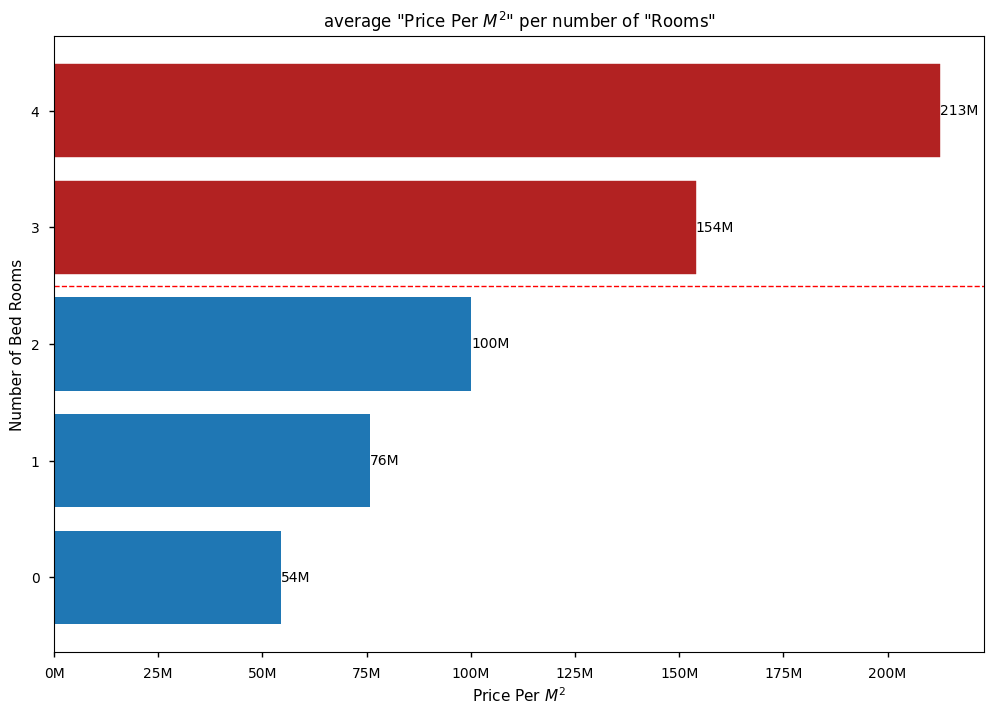

In [9]:
rooms_price = df.groupby('Rooms').agg({'PricePerM2': lambda x: x.mean()})
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
# rooms_price   
bars = ax.barh(rooms_price.index, rooms_price['PricePerM2'])
ax.axhline(y=2.5, linewidth=1, color='r', linestyle='--')
bars[3].set_color('firebrick')
bars[4].set_color('firebrick')
ax.set_title('average "Price Per $M^2$" per number of "Rooms"')
ax.set_xlabel('Price Per $M^2$')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:.0f}M".format(x/1e6)))
ax.bar_label(bars, label_type='edge', fmt=lambda x: "{:.0f}M".format(x/1e6))
ax.set_ylabel('Number of Bed Rooms')
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20392\2172603543.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Wistia')


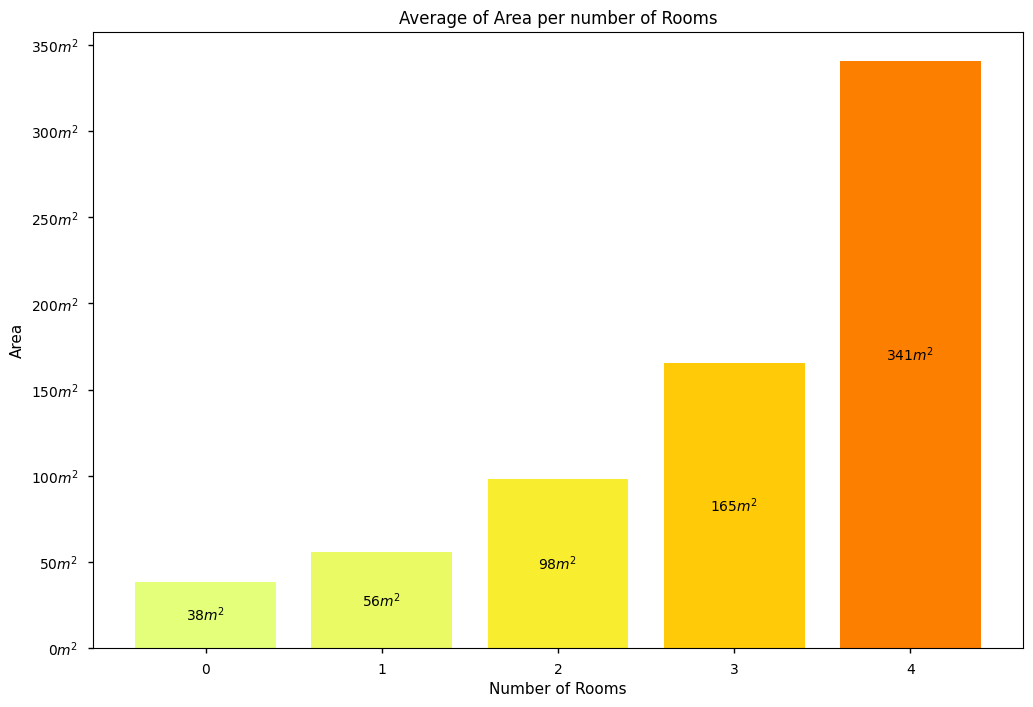

In [10]:
area_per_room = df.groupby('Rooms').agg({'Area': 'mean'})
cmap = cm.get_cmap('Wistia')
rescale = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
bars = ax.bar(area_per_room.index, area_per_room['Area'], color=cmap(rescale(area_per_room['Area'])))
ax.set_xlabel('Number of Rooms')
ax.set_ylabel('Area')
ax.bar_label(bars, fmt=lambda x: "{:.0f}$m^2$".format(x), label_type='center')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _ : '{:.0f}$m^2$'.format(x)))
ax.set_title('Average of Area per number of Rooms')
plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
scaled_data = mm.fit_transform(df.drop('Location', axis=1))
scaled_df = pd.DataFrame(scaled_data, columns=mm.get_feature_names_out())
# corr_df = df.drop('Location', axis=1)
corr = scaled_df.corr()
corr

,Area,Rooms,Floor,PricePerM2,BuildingAge
Area,1.000000,0.721343,0.209093,0.422714,-0.181937
Rooms,0.721343,1.000000,0.222935,0.385500,-0.179177
Floor,0.209093,0.222935,1.000000,0.010880,-0.313969
PricePerM2,0.422714,0.385500,0.010880,1.000000,-0.160118
BuildingAge,-0.181937,-0.179177,-0.313969,-0.160118,1.000000


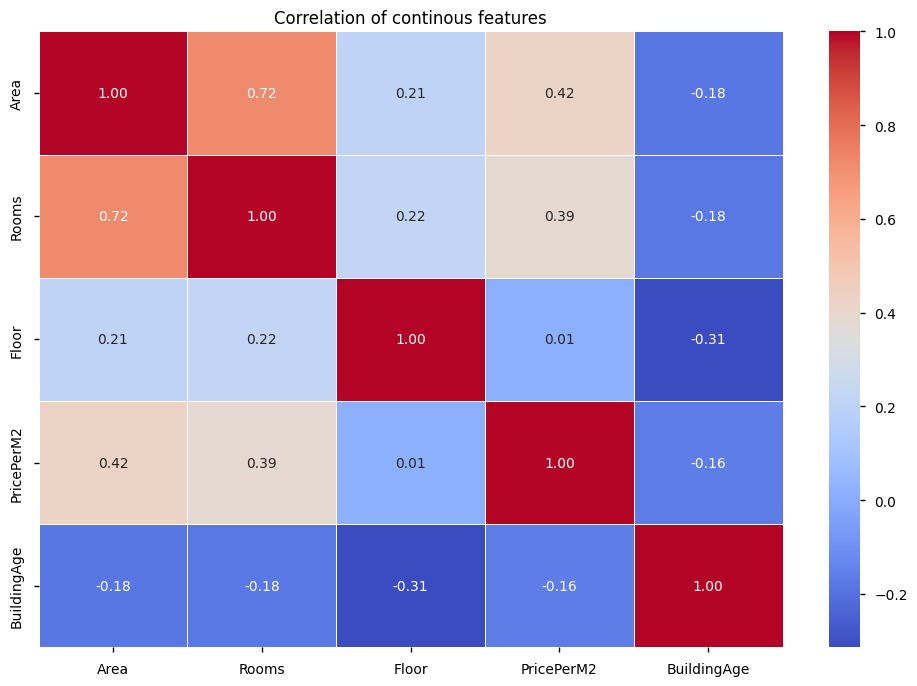

In [12]:
figure = plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation of continous features')
plt.show()

In [17]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans


def scale_continous_features(df, columns, method):
    data = df.loc[:, columns]
    scaled_data = method.fit_transform(data)
    return pd.DataFrame(data=scaled_data, columns=method.get_feature_names_out())


def convert_categorical_features(df, columns, method):
    data = df.loc[:, columns]
    transformed_data = method.fit_transform(data.values.reshape(-1, 1))
    return pd.DataFrame(data=transformed_data, columns=method.get_feature_names_out())


continous_columns = ['Area', 'Rooms', 'Floor', 'PricePerM2', 'BuildingAge']
categorical_columns = ['Location']

continous_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False)

transformed_continous_features = scale_continous_features(df, columns=continous_columns, method=continous_transformer)
transformed_categorical_features = convert_categorical_features(df, columns=categorical_columns, method=categorical_transformer)

transformed_df = pd.concat([transformed_continous_features, transformed_categorical_features], axis=1)

In [18]:
transformed_df

,Area,Rooms,Floor,PricePerM2,BuildingAge,x0_آبشار,x0_آبشار تهران,x0_آجودانیه,x0_آذربایجان,x0_آرارات,...,x0_کاشانک,x0_کامرانیه,x0_کرمان,x0_کوهک,x0_کوی فراز,x0_کوی فردوس,x0_گرگان,x0_گیشا (کوی نصر),x0_یافت‌آباد,x0_یوسف‌آباد
0,-0.413431,-0.212847,0.745272,0.536520,-0.810147,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.263086,-0.212847,0.276463,-0.073291,-0.432971,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.782458,-1.530923,-0.661155,-1.039865,-0.307245,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.413431,-0.212847,-0.192346,-0.061149,-0.055794,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.720986,1.105229,-0.426751,1.007083,2.332989,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,0.215282,1.105229,0.276463,-0.408143,1.578636,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
832,-0.386095,-0.212847,-0.426751,-1.028101,-0.810147,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
833,-0.577443,-0.212847,-0.661155,-0.153639,-0.684422,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
834,-0.919135,-1.530923,-0.426751,-0.992809,0.321382,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def optimal_k_number():
    pass